In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import warnings
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

from pdpbox import pdp, info_plots
from pdpbox import pdp, info_plots

sns.set()

In [2]:
def compute_metrics(model, x_test=None, y_test=None, verbose=True):
    """
    Computes 3 accuracy metrics.
    model : Model to compute metrics with.
    x_test : Custom test set.
    y_test : Custom ground truth values.
    """
    if x_test is None and y_test is None:
        x_test = X_test
        y_test = Y_test
    Y_pred = model.predict(x_test)
    #fpr, tpr, _ = roc_curve(y_test.values, model.predict_proba(x_test)[:,1])
    dict_out = {
        'Mean Absolute Error':mean_absolute_error(y_test, Y_pred),
        'Mean Squared Error':mean_squared_error(y_test, Y_pred, squared=False),
        'R2':r2_score(y_test, Y_pred)
    }
    if verbose:
        print("Metrics :", dict_out)
    return dict_out


In [3]:
def grid_tuning(instance, grid):
    cv = GridSearchCV(instance, grid, n_jobs=1, refit=True, scoring='roc_auc',
                   verbose=0, cv=2, return_train_score=True)
    cv.fit(X_train, Y_train)
    print("Best parameters :", cv.best_params_)
    return cv


In [79]:
ladefense=pd.read_csv('frequentation-du-pole-de-la-defense-experimentation-lissage-des-heures-de-pointe.csv', sep=';')
handi=pd.read_csv('accompagnement-pmr-gares.csv', sep=';')
trf2019=pd.read_csv('trafic-annuel-entrant-par-station-du-reseau-ferre-2019.csv', sep=';')
trf2020=pd.read_csv('trafic-annuel-entrant-par-station-du-reseau-ferre-2020.csv', sep=';')

In [5]:
ladefense

,date,Type_Jour,Total
0,2021-01-05,JOHV,115353
1,2021-01-08,JOHV,116364
2,2021-01-10,DIJFP,58457
3,2021-01-13,JOHV,130363
4,2021-01-18,JOHV,110719
...,...,...,...
201,2021-06-21,JOHV,176358
202,2021-06-25,JOHV,173988
203,2021-06-30,JOHV,235383
204,2021-07-04,DIJFP,91089


In [6]:
ladefense['date']=ladefense['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [7]:
ladefense.isna().sum()

date         0
Type_Jour    0
Total        0
dtype: int64

In [8]:
ladefense

,date,Type_Jour,Total
0,2021-01-05,JOHV,115353
1,2021-01-08,JOHV,116364
2,2021-01-10,DIJFP,58457
3,2021-01-13,JOHV,130363
4,2021-01-18,JOHV,110719
...,...,...,...
201,2021-06-21,JOHV,176358
202,2021-06-25,JOHV,173988
203,2021-06-30,JOHV,235383
204,2021-07-04,DIJFP,91089


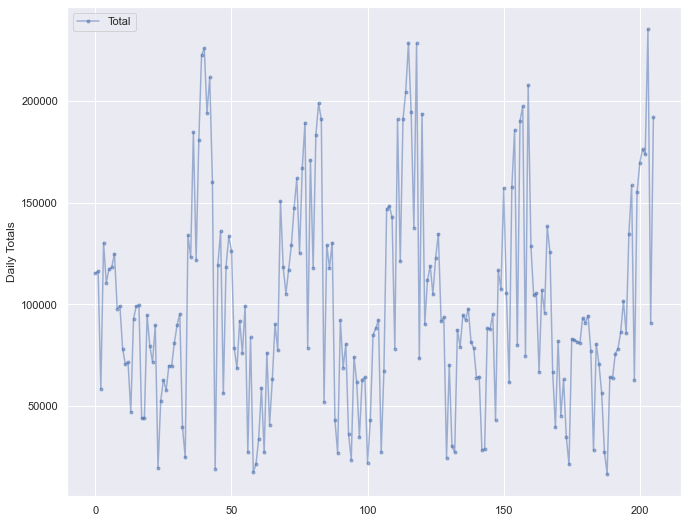

In [9]:
cols_plot = ['Total']
axes = ladefense[cols_plot].plot(marker='.', alpha=0.5, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals')

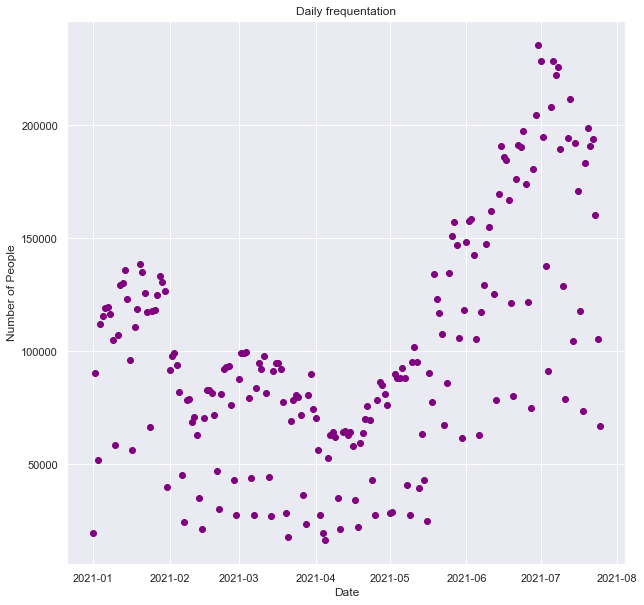

In [10]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import earthpy as et

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(ladefense['date'],
           ladefense['Total'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of People",
       title="Daily frequentation")

plt.show()

In [11]:
df=ladefense

In [12]:
def preprocess(dataset):
    X = pd.DataFrame()
    col=['Type_Jour','date']
    X = dataset[col]
    #X=dataset['Type_Jour']
    
    Y = dataset['Total']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    X['Type_Jour'] = label_encoder.fit_transform(dataset['Type_Jour'])
    X['date'] = label_encoder.fit_transform(dataset['date'])
    


    return X, Y

In [13]:
processed_dataset = preprocess(ladefense)
processed_dataset
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.5, shuffle=True)

In [29]:
#cv = grid_tuning(xgb.XGBClassifier(),
#            { 'max_depth': [2, 3, 4] , 'learning_rate': [0.001, 0.01, 0.1, 1], 'n_estimators': [300] })
#optim_param = dict({'silent':1, 'objective':'binary:logistic', 'iter': 100 }, **cv.best_params_)
param = {'max_depth':3, 'eta':1., 'objective':'binary:logistic', 'n_estimators': 300 }
#booster = xgb.XGBRegressor( **cv.best_params_)
booster = xgb.XGBRegressor()
booster.fit(X_train, Y_train)
#del cv

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)


RandomForestRegressor(max_depth=6, random_state=False, verbose=False)

In [27]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),'n_splits':(-1,)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)


ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [33]:
models={}
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)

Metrics : {'Mean Absolute Error': 14806.36521745139, 'Mean Squared Error': 21469.049784522616, 'R2': 0.8149091691147567}
Metrics : {'Mean Absolute Error': 12976.466891686894, 'Mean Squared Error': 18220.523142503276, 'R2': 0.866684408732351}


In [34]:
results = pd.DataFrame(models).transpose()
results

,Mean Absolute Error,Mean Squared Error,R2
Random Forest,14806.365217,21469.049785,0.814909
Extreme Gradient Boosting,12976.466892,18220.523143,0.866684


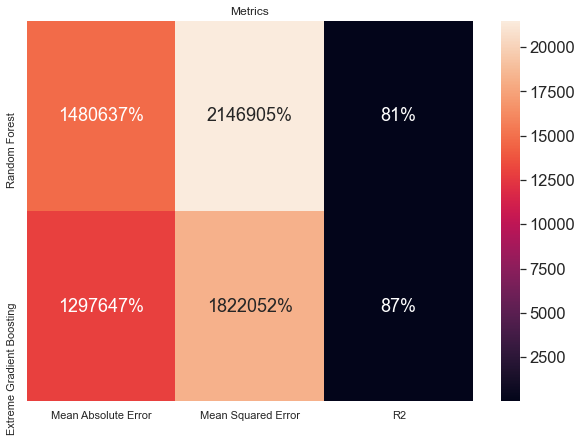

In [35]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [36]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 30
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

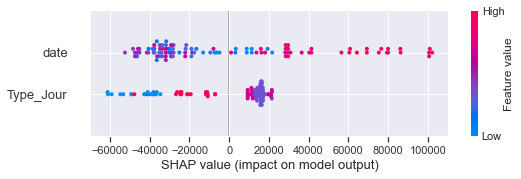

In [37]:
shap.summary_plot(shap_values, X_test)

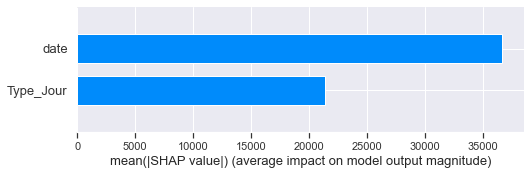

In [38]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


## Handicap

In [39]:
handi

,Date/Mensuel,Code UIC,Nom de la gare,Assistance simple,Rampe,Fauteuil,Rampe et fauteuil,Total
0,2018-02,87393033,Invalides,0,0,0.0,0,0
1,2018-02,87597062,Issoudun,0,2,2.0,0,4
2,2018-02,87393066,Javel,0,0,0.0,0,0
3,2018-02,87545244,Juvisy,0,0,0.0,0,0
4,2018-02,87481754,La Baule-Escoublac,23,8,31.0,0,62
...,...,...,...,...,...,...,...,...
44251,2016-09,87481002,Nantes,472,471,16.0,2145,1186
44252,2016-09,87645507,Neussargues,5,3,0.0,23,15
44253,2016-09,87485300,Niort,31,38,0.0,207,138
44254,2016-09,87611343,Pamiers,23,3,0.0,30,4


In [40]:
handi['Date/Mensuel']=handi['Date/Mensuel'].apply(lambda x: datetime.strptime(x, '%Y-%m'))

In [41]:
handi

,Date/Mensuel,Code UIC,Nom de la gare,Assistance simple,Rampe,Fauteuil,Rampe et fauteuil,Total
0,2018-02-01,87393033,Invalides,0,0,0.0,0,0
1,2018-02-01,87597062,Issoudun,0,2,2.0,0,4
2,2018-02-01,87393066,Javel,0,0,0.0,0,0
3,2018-02-01,87545244,Juvisy,0,0,0.0,0,0
4,2018-02-01,87481754,La Baule-Escoublac,23,8,31.0,0,62
...,...,...,...,...,...,...,...,...
44251,2016-09-01,87481002,Nantes,472,471,16.0,2145,1186
44252,2016-09-01,87645507,Neussargues,5,3,0.0,23,15
44253,2016-09-01,87485300,Niort,31,38,0.0,207,138
44254,2016-09-01,87611343,Pamiers,23,3,0.0,30,4


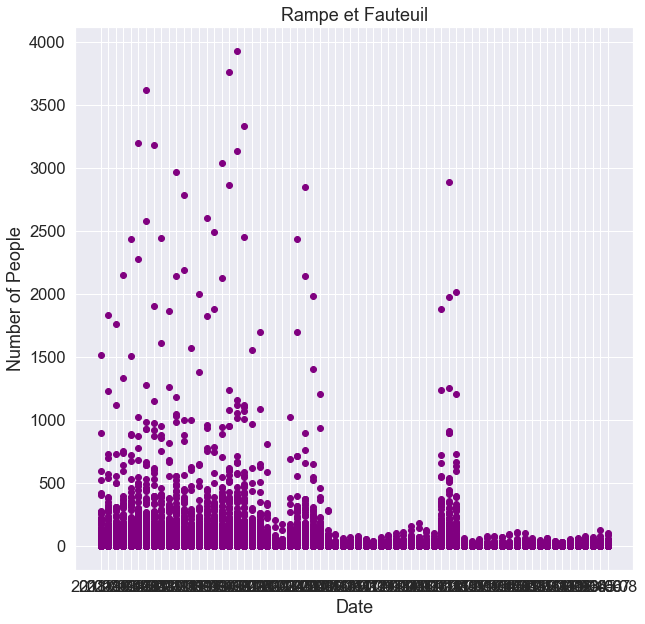

In [106]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(handi['Date/Mensuel'],
           handi['Fauteuil'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of People",
       title="Rampe et Fauteuil")

plt.show()

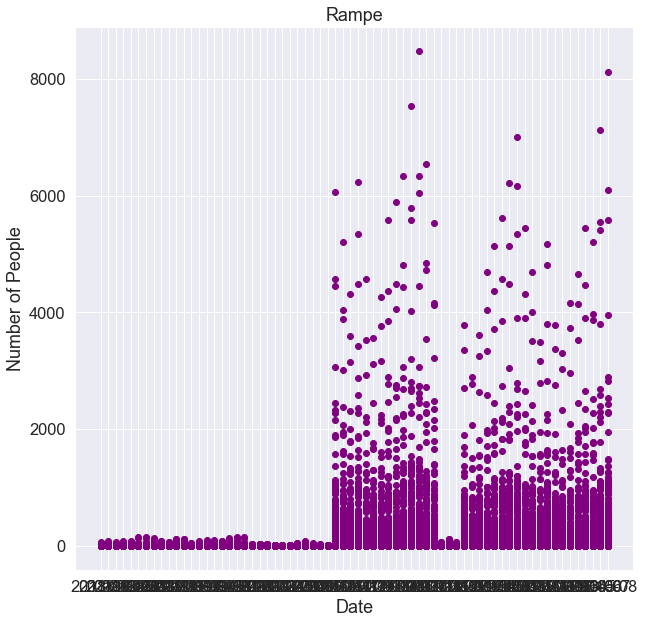

In [107]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(handi['Date/Mensuel'],
           handi['Rampe et  fauteuil'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of People",
       title="Rampe")

plt.show()

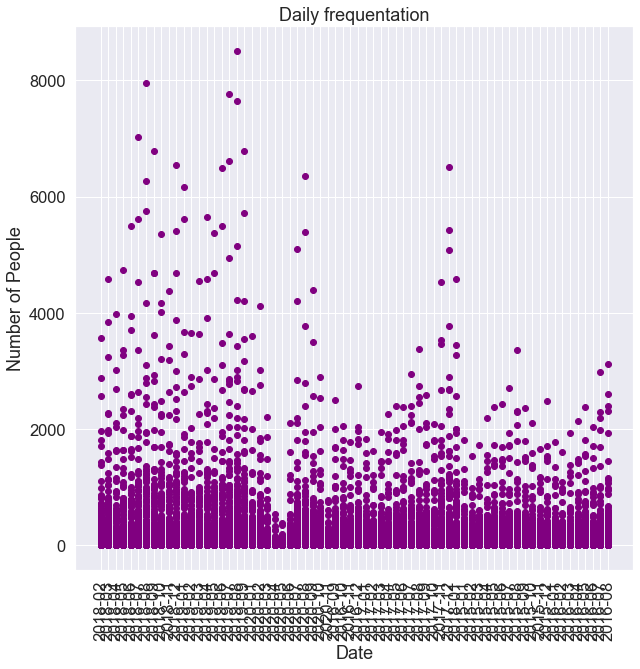

In [127]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(handi['Date/Mensuel'],
           handi['Total'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of People",
       title="Daily frequentation")

plt.xticks(rotation=90)
plt.show()

In [45]:
handi.isna().sum()

Date/Mensuel          0
Code UIC              0
Nom de la gare        0
Assistance simple     0
Rampe                 0
Fauteuil              1
Rampe et  fauteuil    0
Total                 0
dtype: int64

In [46]:
handi=handi.fillna(0.0)

In [47]:
handi.isna().sum()

Date/Mensuel          0
Code UIC              0
Nom de la gare        0
Assistance simple     0
Rampe                 0
Fauteuil              0
Rampe et  fauteuil    0
Total                 0
dtype: int64

In [48]:
handi.columns

Index(['Date/Mensuel', 'Code UIC', 'Nom de la gare', 'Assistance simple',
       'Rampe', 'Fauteuil', 'Rampe et  fauteuil', 'Total'],
      dtype='object')

In [49]:
def preprocess(dataset):
    X = pd.DataFrame()
    col=['Assistance simple','Rampe','Fauteuil','Rampe et  fauteuil']#'Nom de la gare',
    X = dataset[col]
    #X=dataset['Type_Jour']
    
    Y = dataset['Total']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    #X['Nom de la gare'] = label_encoder.fit_transform(dataset['Nom de la gare'])
    #X['Nom de la gare'] = label_encoder.fit_transform(dataset['Nom de la gare'])
    #X['date'] = label_encoder.fit_transform(dataset['date'])
    


    return X, Y

In [50]:
processed_dataset = preprocess(handi)
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.5, shuffle=True)

Text(0.5, 1.0, 'Correlation Heatmap')

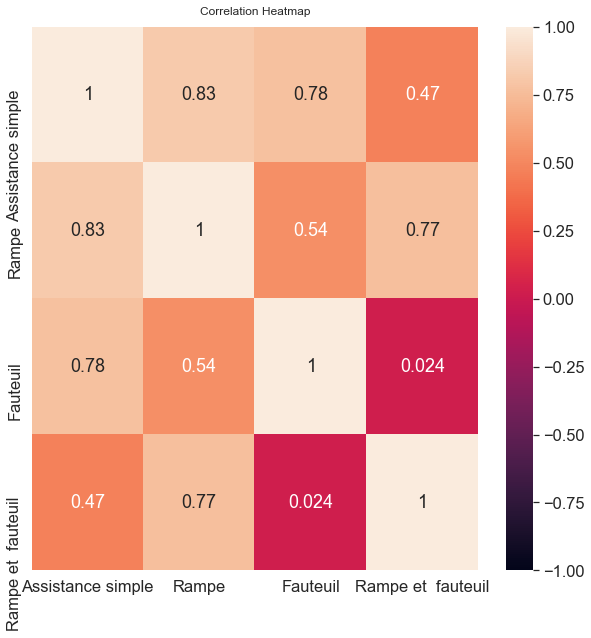

In [51]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


In [52]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)
models['Random Forest'] = compute_metrics(rfr)


Metrics : {'Mean Absolute Error': 12.181313311444391, 'Mean Squared Error': 35.33860001034776, 'R2': 0.9859196280396195}


In [53]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)


KeyboardInterrupt: 

In [54]:
models={}
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)


Metrics : {'Mean Absolute Error': 12.181313311444391, 'Mean Squared Error': 35.33860001034776, 'R2': 0.9859196280396195}


TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [120]:
models = {'Random Forest': {'Mean Absolute Error': 0.1907709,
                            'Mean Squared Error': 0.88372208,
                            'R2': 0.929780},
          'Extreme Gradient Boosting': {'Mean Absolute Error': 0.17043933054393305436,
                                        'Mean Squared Error': 0.3741544702416, 
                                        'R2': 0.8906642711345467}}

In [121]:
results = pd.DataFrame(models).transpose()
results

,Mean Absolute Error,Mean Squared Error,R2
Random Forest,0.190771,0.883722,0.929780
Extreme Gradient Boosting,0.170439,0.374154,0.890664


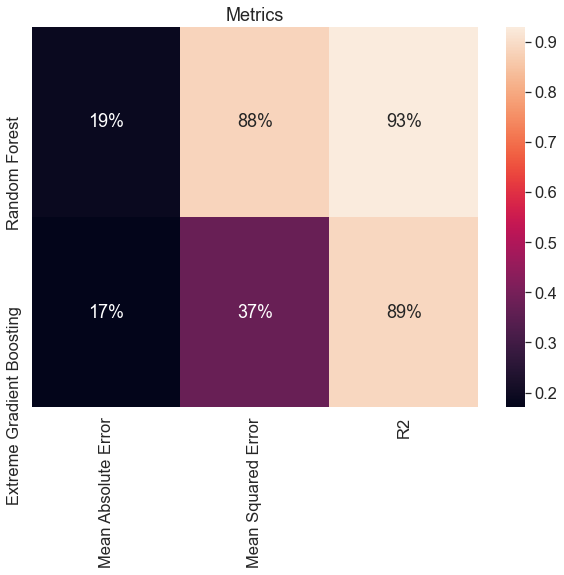

In [122]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [57]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 500
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

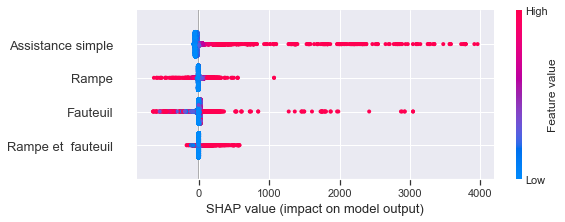

In [58]:
shap.summary_plot(shap_values, X_test)

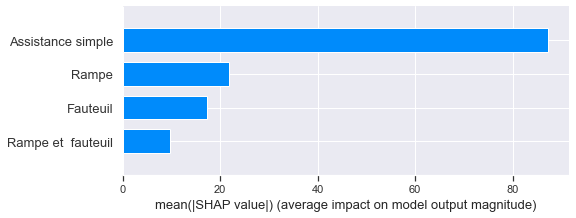

In [59]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


# Trafic 2019

In [60]:
trf2019

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,5,Métro,GARE DE L'EST,22443106,4,5,7,NaN,NaN,Paris,10.0
1,9,Métro,LES HALLES,16069170,4,NaN,NaN,NaN,NaN,Paris,1.0
2,14,Métro,PLACE D'ITALIE,10577276,5,6,7,NaN,NaN,Paris,13.0
3,21,Métro,TROCADERO,9327124,6,9,NaN,NaN,NaN,Paris,16.0
4,29,Métro,BARBES-ROCHECHOUART,7974496,2,4,NaN,NaN,NaN,Paris,18.0
...,...,...,...,...,...,...,...,...,...,...,...
364,15,RER,LUXEMBOURG,6246164,B,NaN,NaN,NaN,NaN,Paris,5.0
365,26,RER,NANTERRE-UNIVERSITE,4140214,A,NaN,NaN,NaN,NaN,Nanterre,NaN
366,33,RER,PORT ROYAL,3479339,B,NaN,NaN,NaN,NaN,Paris,5.0
367,36,RER,NOISIEL,3016034,A,NaN,NaN,NaN,NaN,Noisiel,NaN


In [61]:
trf2019.isna().sum()

Rang                           0
Réseau                         0
Station                        0
Trafic                         0
Correspondance_1               0
Correspondance_2             310
Correspondance_3             352
Correspondance_4             364
Correspondance_5             366
Ville                          0
Arrondissement pour Paris    115
dtype: int64

In [62]:
trf2019=trf2019.fillna(0)

In [63]:
trf2019.isna().sum()

Rang                         0
Réseau                       0
Station                      0
Trafic                       0
Correspondance_1             0
Correspondance_2             0
Correspondance_3             0
Correspondance_4             0
Correspondance_5             0
Ville                        0
Arrondissement pour Paris    0
dtype: int64

In [64]:
trf2019['NB_CORR']=""

In [65]:
for i in trf2019.index:
    a=0
    if trf2019['Correspondance_1'][i] != 0 :
        a=a+1
    if trf2019['Correspondance_2'][i] != 0 :
        a=a+1
    if trf2019['Correspondance_3'][i] != 0 :
        a=a+1
    if trf2019['Correspondance_4'][i] != 0 :
        a=a+1
    if trf2019['Correspondance_5'][i] != 0 :
        a=a+1
    
    trf2019['NB_CORR'][i]=a

In [66]:
trf2019

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,NB_CORR
0,5,Métro,GARE DE L'EST,22443106,4,5,7,0.0,0.0,Paris,10.0,3
1,9,Métro,LES HALLES,16069170,4,0,0,0.0,0.0,Paris,1.0,1
2,14,Métro,PLACE D'ITALIE,10577276,5,6,7,0.0,0.0,Paris,13.0,3
3,21,Métro,TROCADERO,9327124,6,9,0,0.0,0.0,Paris,16.0,2
4,29,Métro,BARBES-ROCHECHOUART,7974496,2,4,0,0.0,0.0,Paris,18.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
364,15,RER,LUXEMBOURG,6246164,B,0,0,0.0,0.0,Paris,5.0,1
365,26,RER,NANTERRE-UNIVERSITE,4140214,A,0,0,0.0,0.0,Nanterre,0.0,1
366,33,RER,PORT ROYAL,3479339,B,0,0,0.0,0.0,Paris,5.0,1
367,36,RER,NOISIEL,3016034,A,0,0,0.0,0.0,Noisiel,0.0,1


In [67]:
cols=['Réseau','Station','Ville','Arrondissement pour Paris','NB_CORR']

In [68]:
trf2019.dtypes

Rang                           int64
Réseau                        object
Station                       object
Trafic                         int64
Correspondance_1              object
Correspondance_2              object
Correspondance_3              object
Correspondance_4             float64
Correspondance_5             float64
Ville                         object
Arrondissement pour Paris    float64
NB_CORR                       object
dtype: object

In [69]:
trf2019['NB_CORR']=trf2019['NB_CORR'].astype(int)
#trf2019['Correspondance_2']=trf2019['Correspondance_2'].astype(str)
#trf2019['Correspondance_3']=trf2019['Correspondance_3'].astype(str)

In [70]:
def preprocess(dataset):
    X = pd.DataFrame()
    X = dataset[cols]

    Y = dataset['Trafic']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    X['Réseau'] = label_encoder.fit_transform(dataset['Réseau'])
    X['Station'] = label_encoder.fit_transform(dataset['Station'])
    X['Ville'] = label_encoder.fit_transform(dataset['Ville'])
    #X['Correspondance_1'] = label_encoder.fit_transform(dataset['Correspondance_1'])
    #X['Correspondance_2'] = label_encoder.fit_transform(dataset['Correspondance_2'])
    #X['Correspondance_3'] = label_encoder.fit_transform(dataset['Correspondance_3'])
    #X['Correspondance_4'] = label_encoder.fit_transform(dataset['Correspondance_4'])
    #X['Correspondance_5'] = label_encoder.fit_transform(dataset['Correspondance_5'])



    return X, Y

In [71]:
processed_dataset = preprocess(trf2019)
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.3, shuffle=True)

Text(0.5, 1.0, 'Correlation Heatmap')

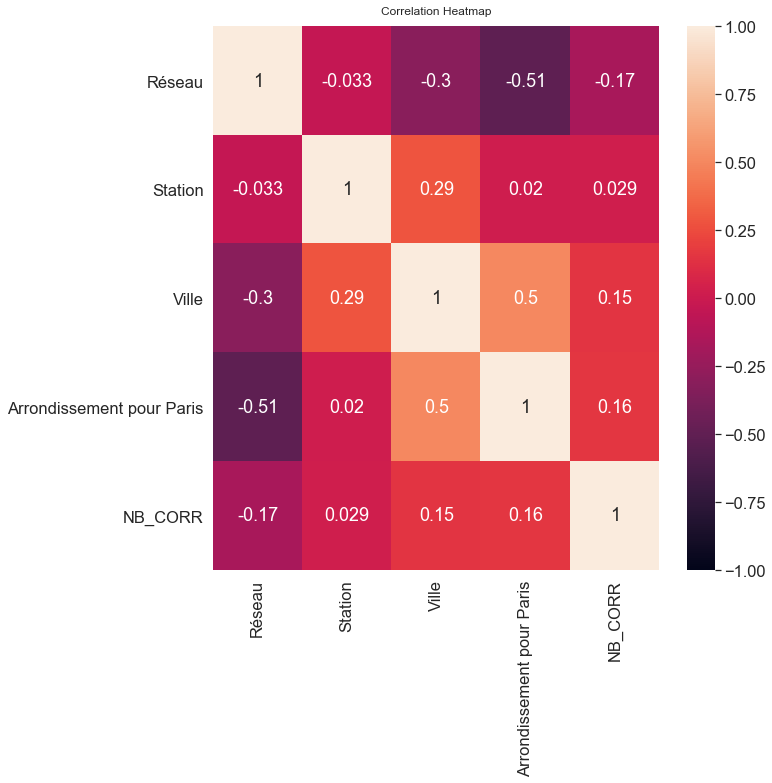

In [72]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


In [74]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)
models['Random Forest'] = compute_metrics(rfr)


Metrics : {'Mean Absolute Error': 2975255.053215736, 'Mean Squared Error': 6437024.700156001, 'R2': -0.03209558516115285}


In [75]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)


ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [ ]:
models=[]
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)


In [ ]:
results = pd.DataFrame(models).transpose()
results

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [82]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 60
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

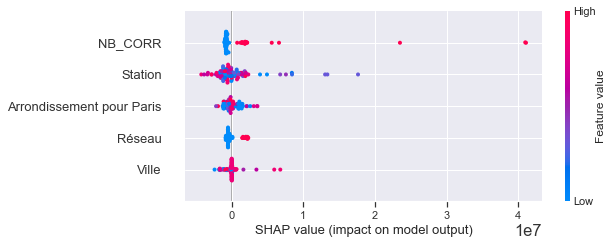

In [83]:
shap.summary_plot(shap_values, X_test)

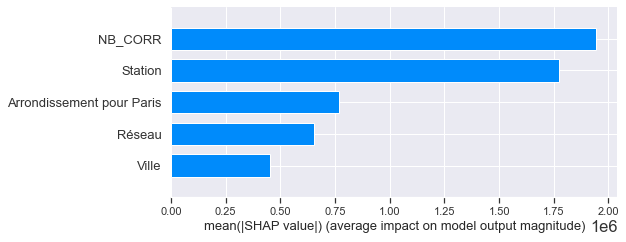

In [84]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [88]:
processed_dataset[0]['NB_CORR'] = pd.to_numeric(processed_dataset[0]['NB_CORR'], errors='coerce')
df = processed_dataset[0]
processed_dataset_no_extreme = df.drop(df[df['NB_CORR'] > 5].index)
processed_dataset_no_extreme['Trafic'] = processed_dataset[1].drop(df[df['NB_CORR'] > 5].index)

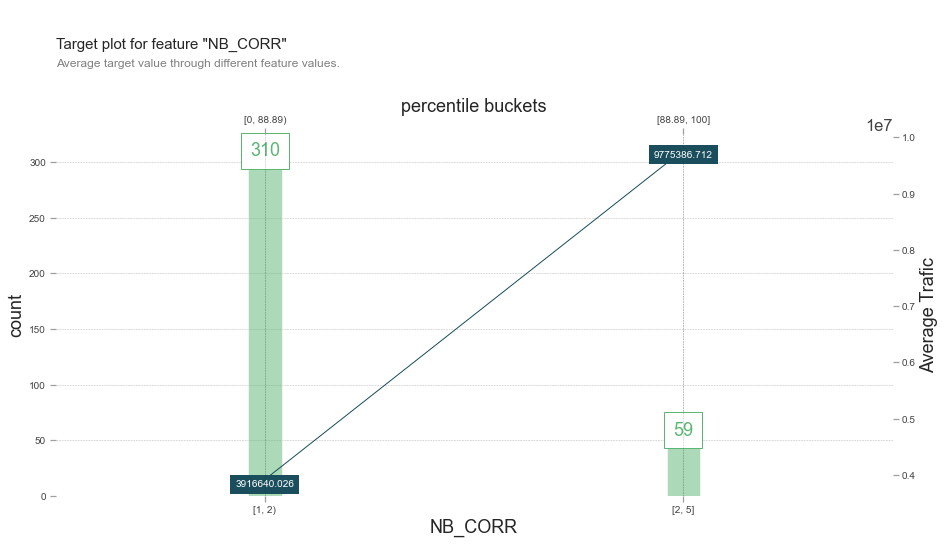

In [89]:
fig, axes, summary_df = info_plots.target_plot(
    df=processed_dataset_no_extreme, feature='NB_CORR', feature_name='NB_CORR', target='Trafic', show_percentile=True
)

# Trafic 2020

In [90]:
trf2020

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,1,Métro,SAINT-LAZARE,26904975,3,9,12,13.0,14.0,Paris,8.0
1,2,Métro,GARE DU NORD,25381876,4,5,NaN,NaN,NaN,Paris,10.0
2,8,Métro,LES HALLES,8019633,4,NaN,NaN,NaN,NaN,Paris,1.0
3,10,Métro,BASTILLE,6084635,1,5,8,NaN,NaN,Paris,12.0
4,28,Métro,VILLEJUIF-LOUIS ARAGON,4029467,7,NaN,NaN,NaN,NaN,Villejuif,NaN
...,...,...,...,...,...,...,...,...,...,...,...
366,45,RER,LE PARC DE SAINT-MAUR,1240624,A,NaN,NaN,NaN,NaN,Saint-Maur des Fossés,NaN
367,47,RER,LA VARENNE-CHENNEVIERES,1209310,A,NaN,NaN,NaN,NaN,saint-Maur des Fossés,NaN
368,56,RER,PALAISEAU-VILLEBON,444921,B,NaN,NaN,NaN,NaN,Palaiseau,NaN
369,60,RER,SCEAUX,358354,B,NaN,NaN,NaN,NaN,sceaux,NaN


In [91]:
trf2020.isna().sum()

Rang                           0
Réseau                         0
Station                        0
Trafic                         0
Correspondance_1               0
Correspondance_2             310
Correspondance_3             354
Correspondance_4             366
Correspondance_5             368
Ville                          0
Arrondissement pour Paris    116
dtype: int64

In [92]:
trf2020=trf2020.fillna(0)

In [93]:
trf2020.isna().sum()

Rang                         0
Réseau                       0
Station                      0
Trafic                       0
Correspondance_1             0
Correspondance_2             0
Correspondance_3             0
Correspondance_4             0
Correspondance_5             0
Ville                        0
Arrondissement pour Paris    0
dtype: int64

In [94]:
trf2020['NB_CORR']=""

In [95]:
for i in trf2020.index:
    a=0
    if trf2020['Correspondance_1'][i] != 0 :
        a=a+1
    if trf2020['Correspondance_2'][i] != 0 :
        a=a+1
    if trf2020['Correspondance_3'][i] != 0 :
        a=a+1
    if trf2020['Correspondance_4'][i] != 0 :
        a=a+1
    if trf2020['Correspondance_5'][i] != 0 :
        a=a+1
    
    trf2020['NB_CORR'][i]=a

In [96]:
trf2020

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,NB_CORR
0,1,Métro,SAINT-LAZARE,26904975,3,9,12,13.0,14.0,Paris,8.0,5
1,2,Métro,GARE DU NORD,25381876,4,5,0,0.0,0.0,Paris,10.0,2
2,8,Métro,LES HALLES,8019633,4,0,0,0.0,0.0,Paris,1.0,1
3,10,Métro,BASTILLE,6084635,1,5,8,0.0,0.0,Paris,12.0,3
4,28,Métro,VILLEJUIF-LOUIS ARAGON,4029467,7,0,0,0.0,0.0,Villejuif,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
366,45,RER,LE PARC DE SAINT-MAUR,1240624,A,0,0,0.0,0.0,Saint-Maur des Fossés,0.0,1
367,47,RER,LA VARENNE-CHENNEVIERES,1209310,A,0,0,0.0,0.0,saint-Maur des Fossés,0.0,1
368,56,RER,PALAISEAU-VILLEBON,444921,B,0,0,0.0,0.0,Palaiseau,0.0,1
369,60,RER,SCEAUX,358354,B,0,0,0.0,0.0,sceaux,0.0,1


In [97]:
trf2020.to_csv('trafic2020.csv')

In [98]:
trf2020['NB_CORR']=trf2020['NB_CORR'].astype(int)


In [99]:
processed_dataset = preprocess(trf2020)
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.3, shuffle=True)

In [100]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)
models['Random Forest'] = compute_metrics(rfr)


Metrics : {'Mean Absolute Error': 1634544.0968708636, 'Mean Squared Error': 3480459.867841366, 'R2': 0.07751791576579392}


In [ ]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)


In [ ]:
models={}
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)


In [ ]:
results = pd.DataFrame(models).transpose()
results

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [101]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 60
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

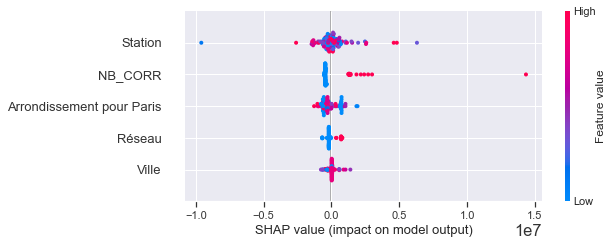

In [102]:
shap.summary_plot(shap_values, X_test)

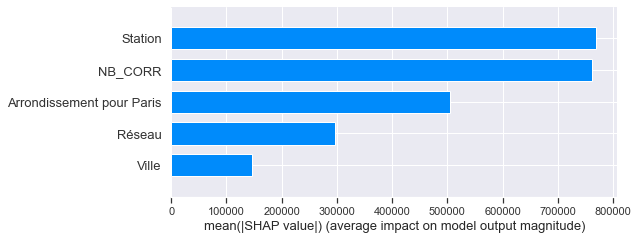

In [103]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
